# Parse the signals according to TTL signal

## Import packages and specify path

In [2]:
import pandas as pd
import neurokit as nk

In [3]:
dir_path = 'C:\\Users\\sangfrois\\physiological-signals\\original-data\\'
subject_path = 'sub-01\\'
exp_path = 'ses-video001\\'

## Read the signal and push in DataFrame

In [4]:

Biosignals_dataFrame, sampling_rate = nk.read_acqknowledge(dir_path+subject_path+exp_path+'sub-01_ses-video001-ocean11.acq', return_sampling_rate=True)


### Define channels

In [7]:
# associate dict keys to variable names and get a sense of the content with .describe()
ppg = Biosignals_dataFrame['PPG100C']
ecg = Biosignals_dataFrame['ECG100C']
rsp = Biosignals_dataFrame['Custom, HLT100C - A 6']
ttl = Biosignals_dataFrame['TTL']
eda = Biosignals_dataFrame['GSR-EDA100C-MRI']


Populating the interactive namespace from numpy and matplotlib


C:\Users\sangfrois\Documents\Computation\Anaconda3\envs\sangfroisEnv\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


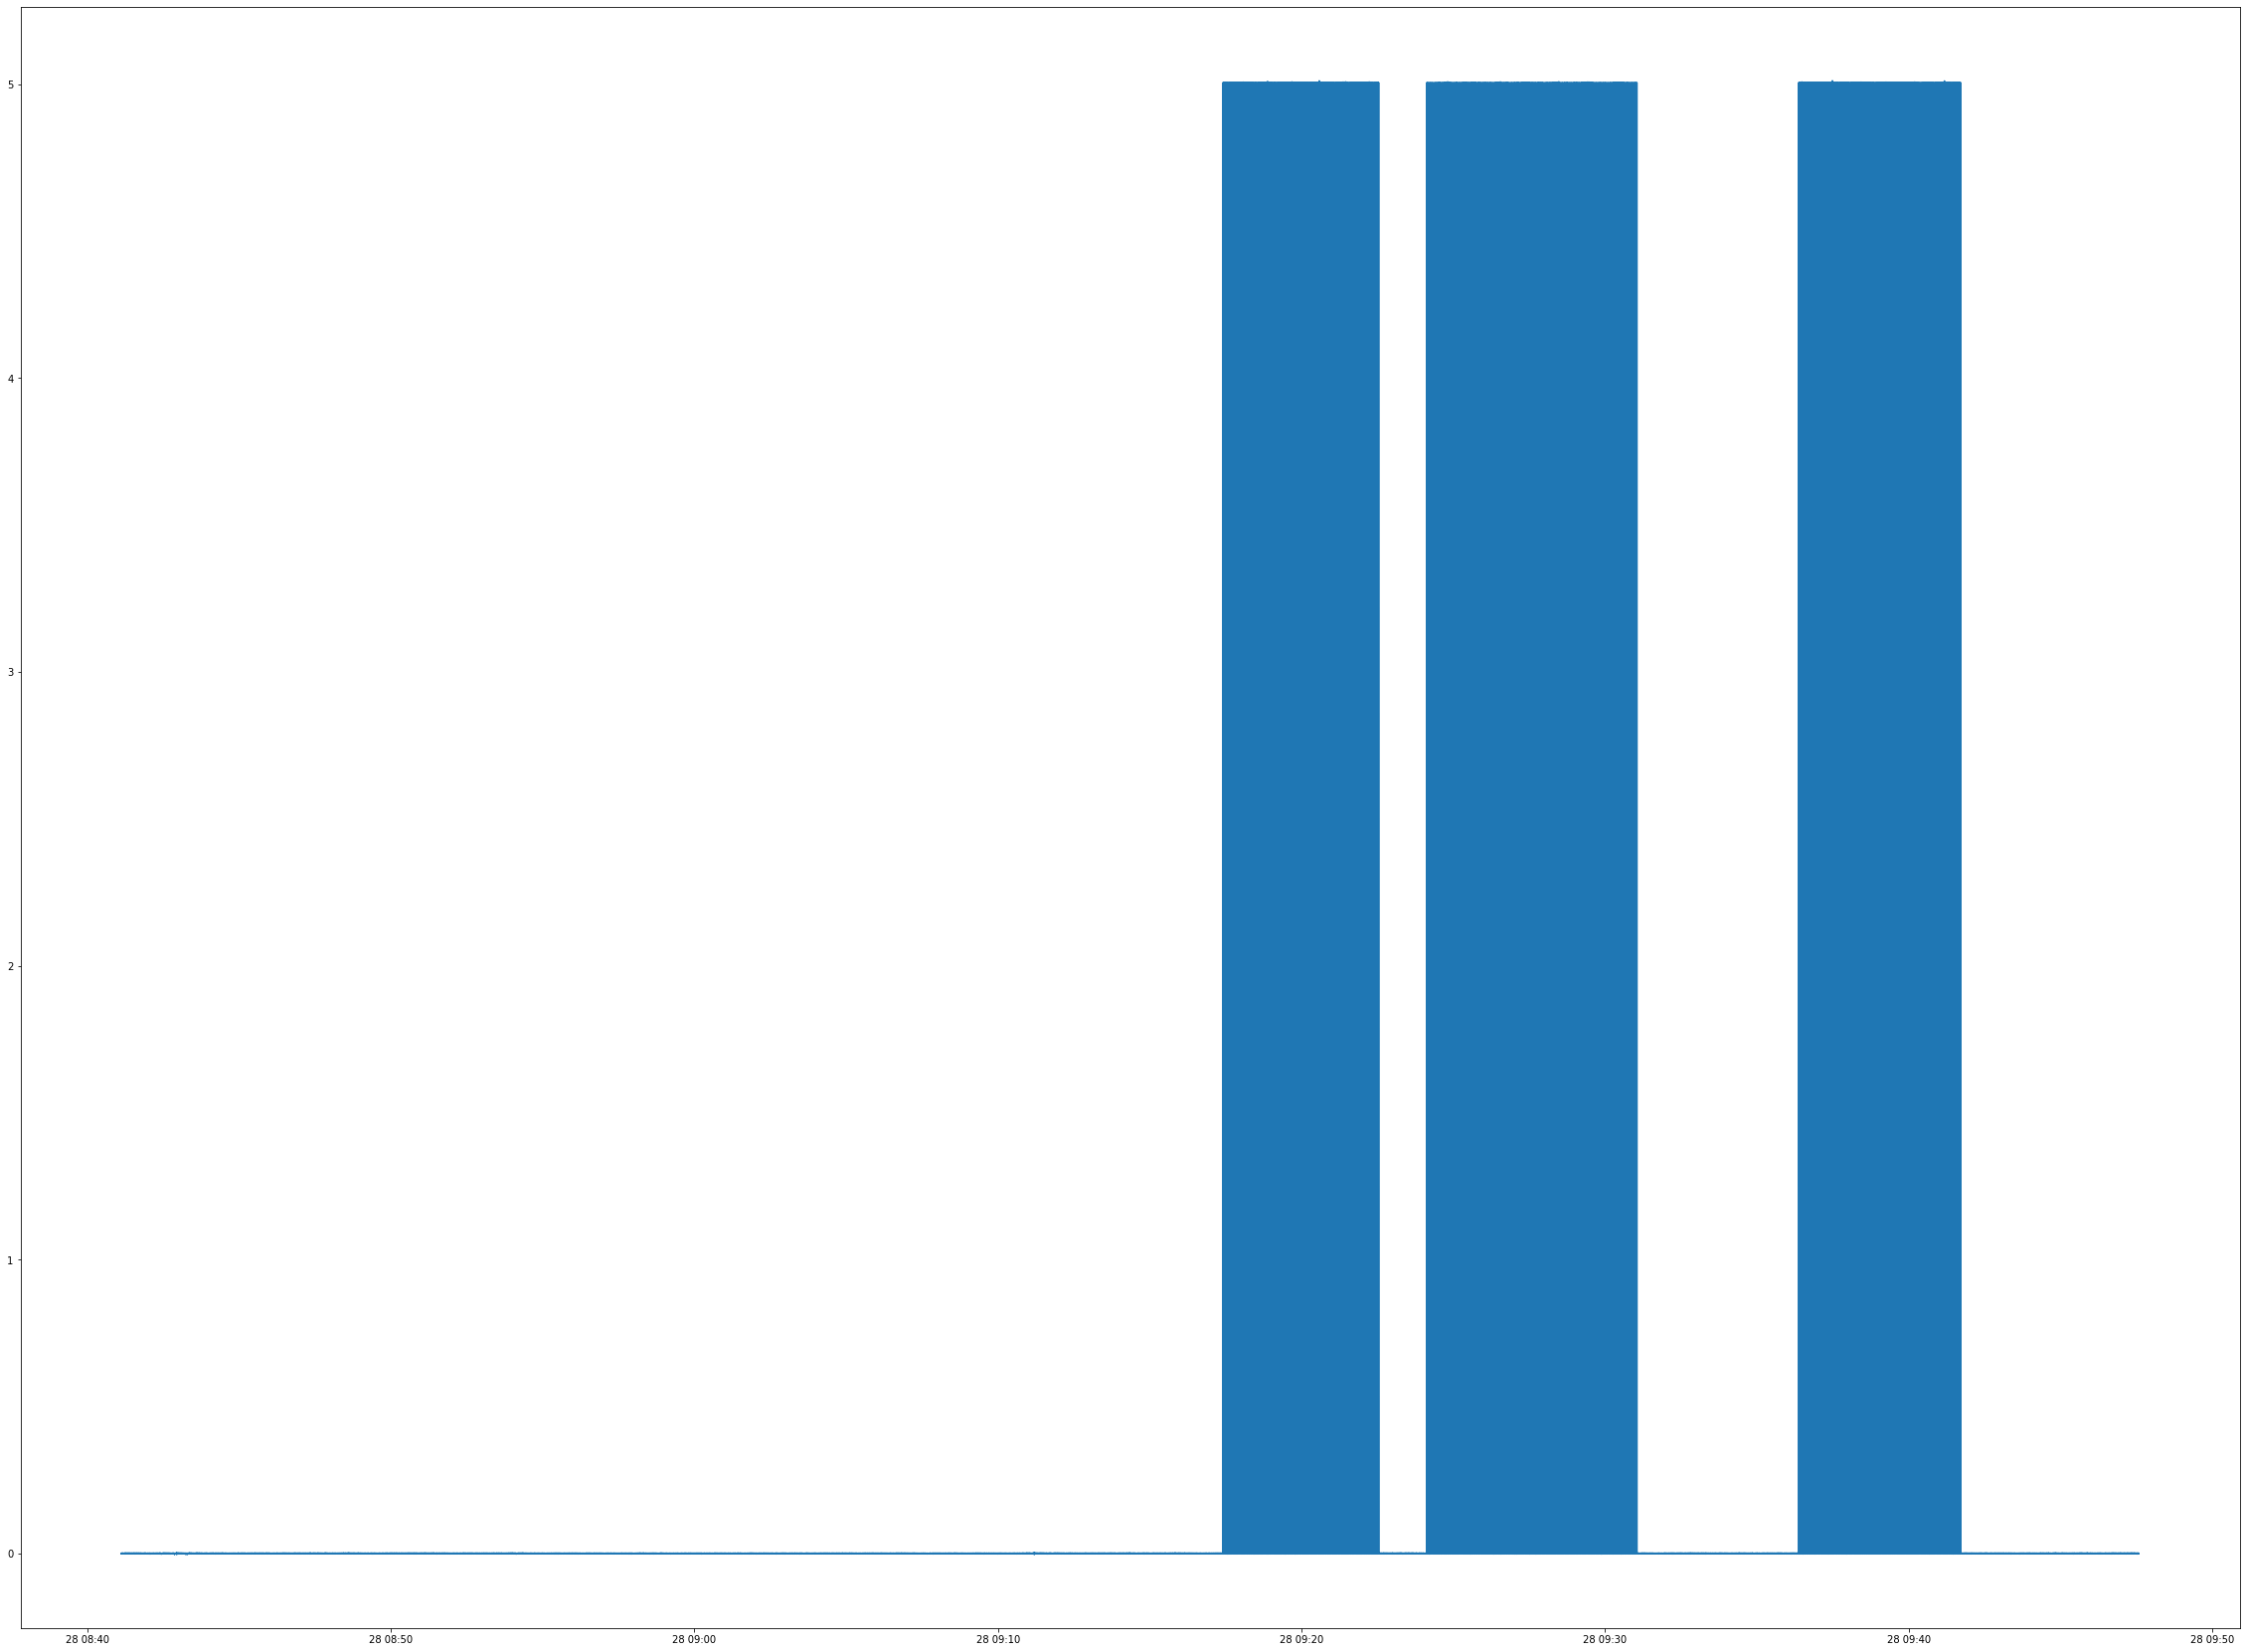

In [20]:
# Look at the TTL
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Make figures a bit bigger
%pylab inline
pylab.rcParams['figure.figsize'] = (40.0, 30.0)  

plt.plot(ttl)

### Define start and end for  the recording session

* ___query_df___ represents every datapoints where TTL channel values are higher than 1, i.e. __the scanner is on__

* Problem is that we can't just take these indexes because __the period between two rows represents the repetition time__ of the scanner's triggers

* TTL values can be high when doing structural (T1) sequences, i.e. around 5 mins

* TTL values can be high when doing BOLD (T2) sequences, i.e. should be 10 mins

*Start* and *End* represent the whole sanning session

*Delta_session* represents the length between the start and end time points

*block_len* is the a priori known minimum scanning block length


In [21]:
import datetime
from datetime import timedelta

query_df = Biosignals_dataFrame.query('TTL > 1')

start, end = query_df.index[[0, -1]]

delta_session = end-start
block_len = timedelta(minutes = 3)



### Define parsing indexes

1. If delta is over a priori known length of block, then query_df has multiple blocks
2. For loop looks in query_df
    1. If finds time values larger than TR period between two adjacent time points ; pushes timestamps in a list
    2. else : ***error***
3. Else
    

In [22]:
parse_list = []

if delta_session > block_len:
    
    tr_period = timedelta(seconds = 2)

    for time in range (len(query_df)-1) :
        
        time_delta = pd.to_datetime(query_df.index[time+1])-pd.to_datetime(query_df.index[time])
        
        if time_delta > tr_period:
            
            parse_start = pd.to_datetime(Biosignals_dataFrame.query('TTL > 1').index[time])
            parse_end = pd.to_datetime(Biosignals_dataFrame.query('TTL > 1').index[time+1])
            
            parse_list += [(parse_start, parse_end)]
        
    
    #Slice mutliple indexes
    #df.loc[('cobra', 'mark i'):('viper', 'mark ii')]
else:
        parse_list += [(start, end)]
print(parse_list)

[(Timestamp('2019-08-28 09:22:32.478597'), Timestamp('2019-08-28 09:24:07.409601')), (Timestamp('2019-08-28 09:31:03.022822'), Timestamp('2019-08-28 09:36:23.143838'))]


#### I end up with a list of Timestamps that goes like this :

parse_list = [(end of rec, start of next), (start of next rec, end of next rec), etc.]

### Keep the first segment before scanner is turned on and name blocks based on Timestamp list

* Block00 is always first index of Biosignal_dataframe to the last index of parse_list; **Biosignal_dataframe.index[0]** 'till **start**

* Block 01 is always from start to first index of parse_list ; **start** 'till **first index of parse_list**

* BlockLast is always last index of parse_list to end ; **parse_list[i][i]** 'till **end**

In [23]:
block00 = Biosignals_dataFrame[Biosignals_dataFrame.index[0]:start]
block01 = Biosignals_dataFrame[start:parse_list[0][0]]
block02 = Biosignals_dataFrame[parse_list[0][1]:parse_list[1][0]]
block03 = Biosignals_dataFrame[parse_list[1][1]:end]


blocks = [ block00, block01 ]
for i in range(len(parse_list)):
    blocks += [Biosignals_dataFrame[parse_list[i][1]:parse_list[1+i][0]]] 
blocks += 

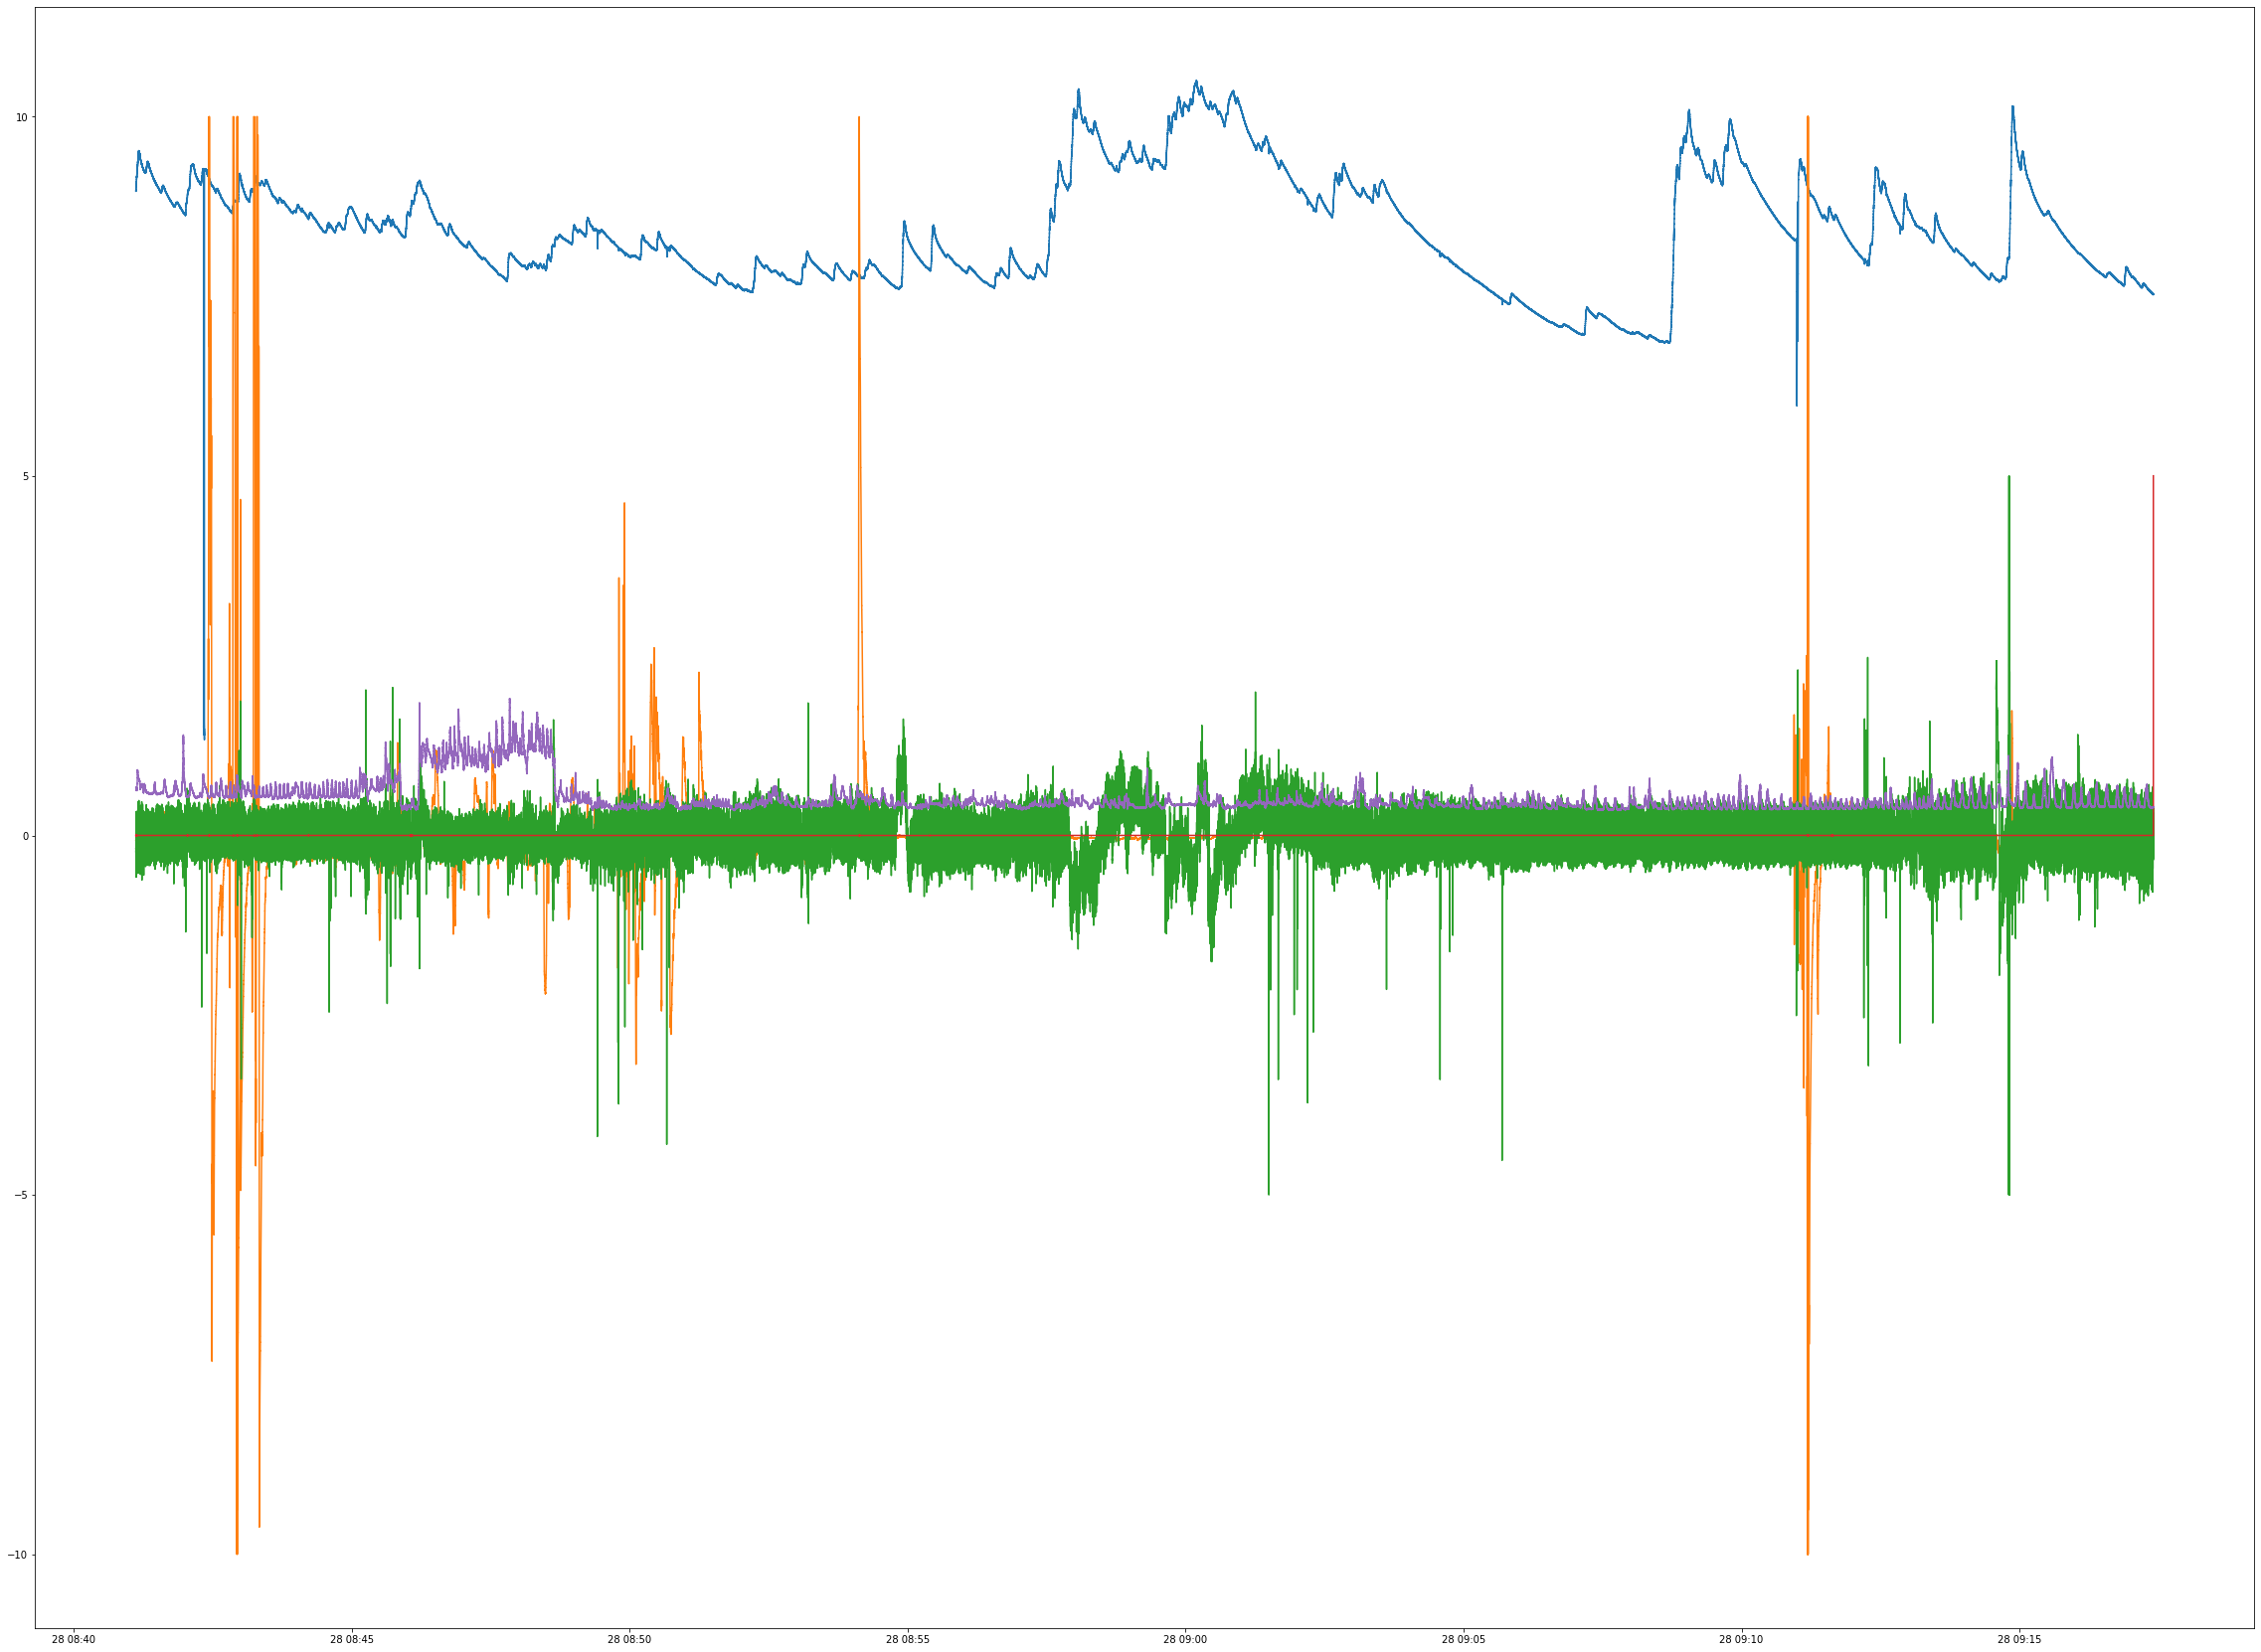

In [24]:

plt.plot(block00)


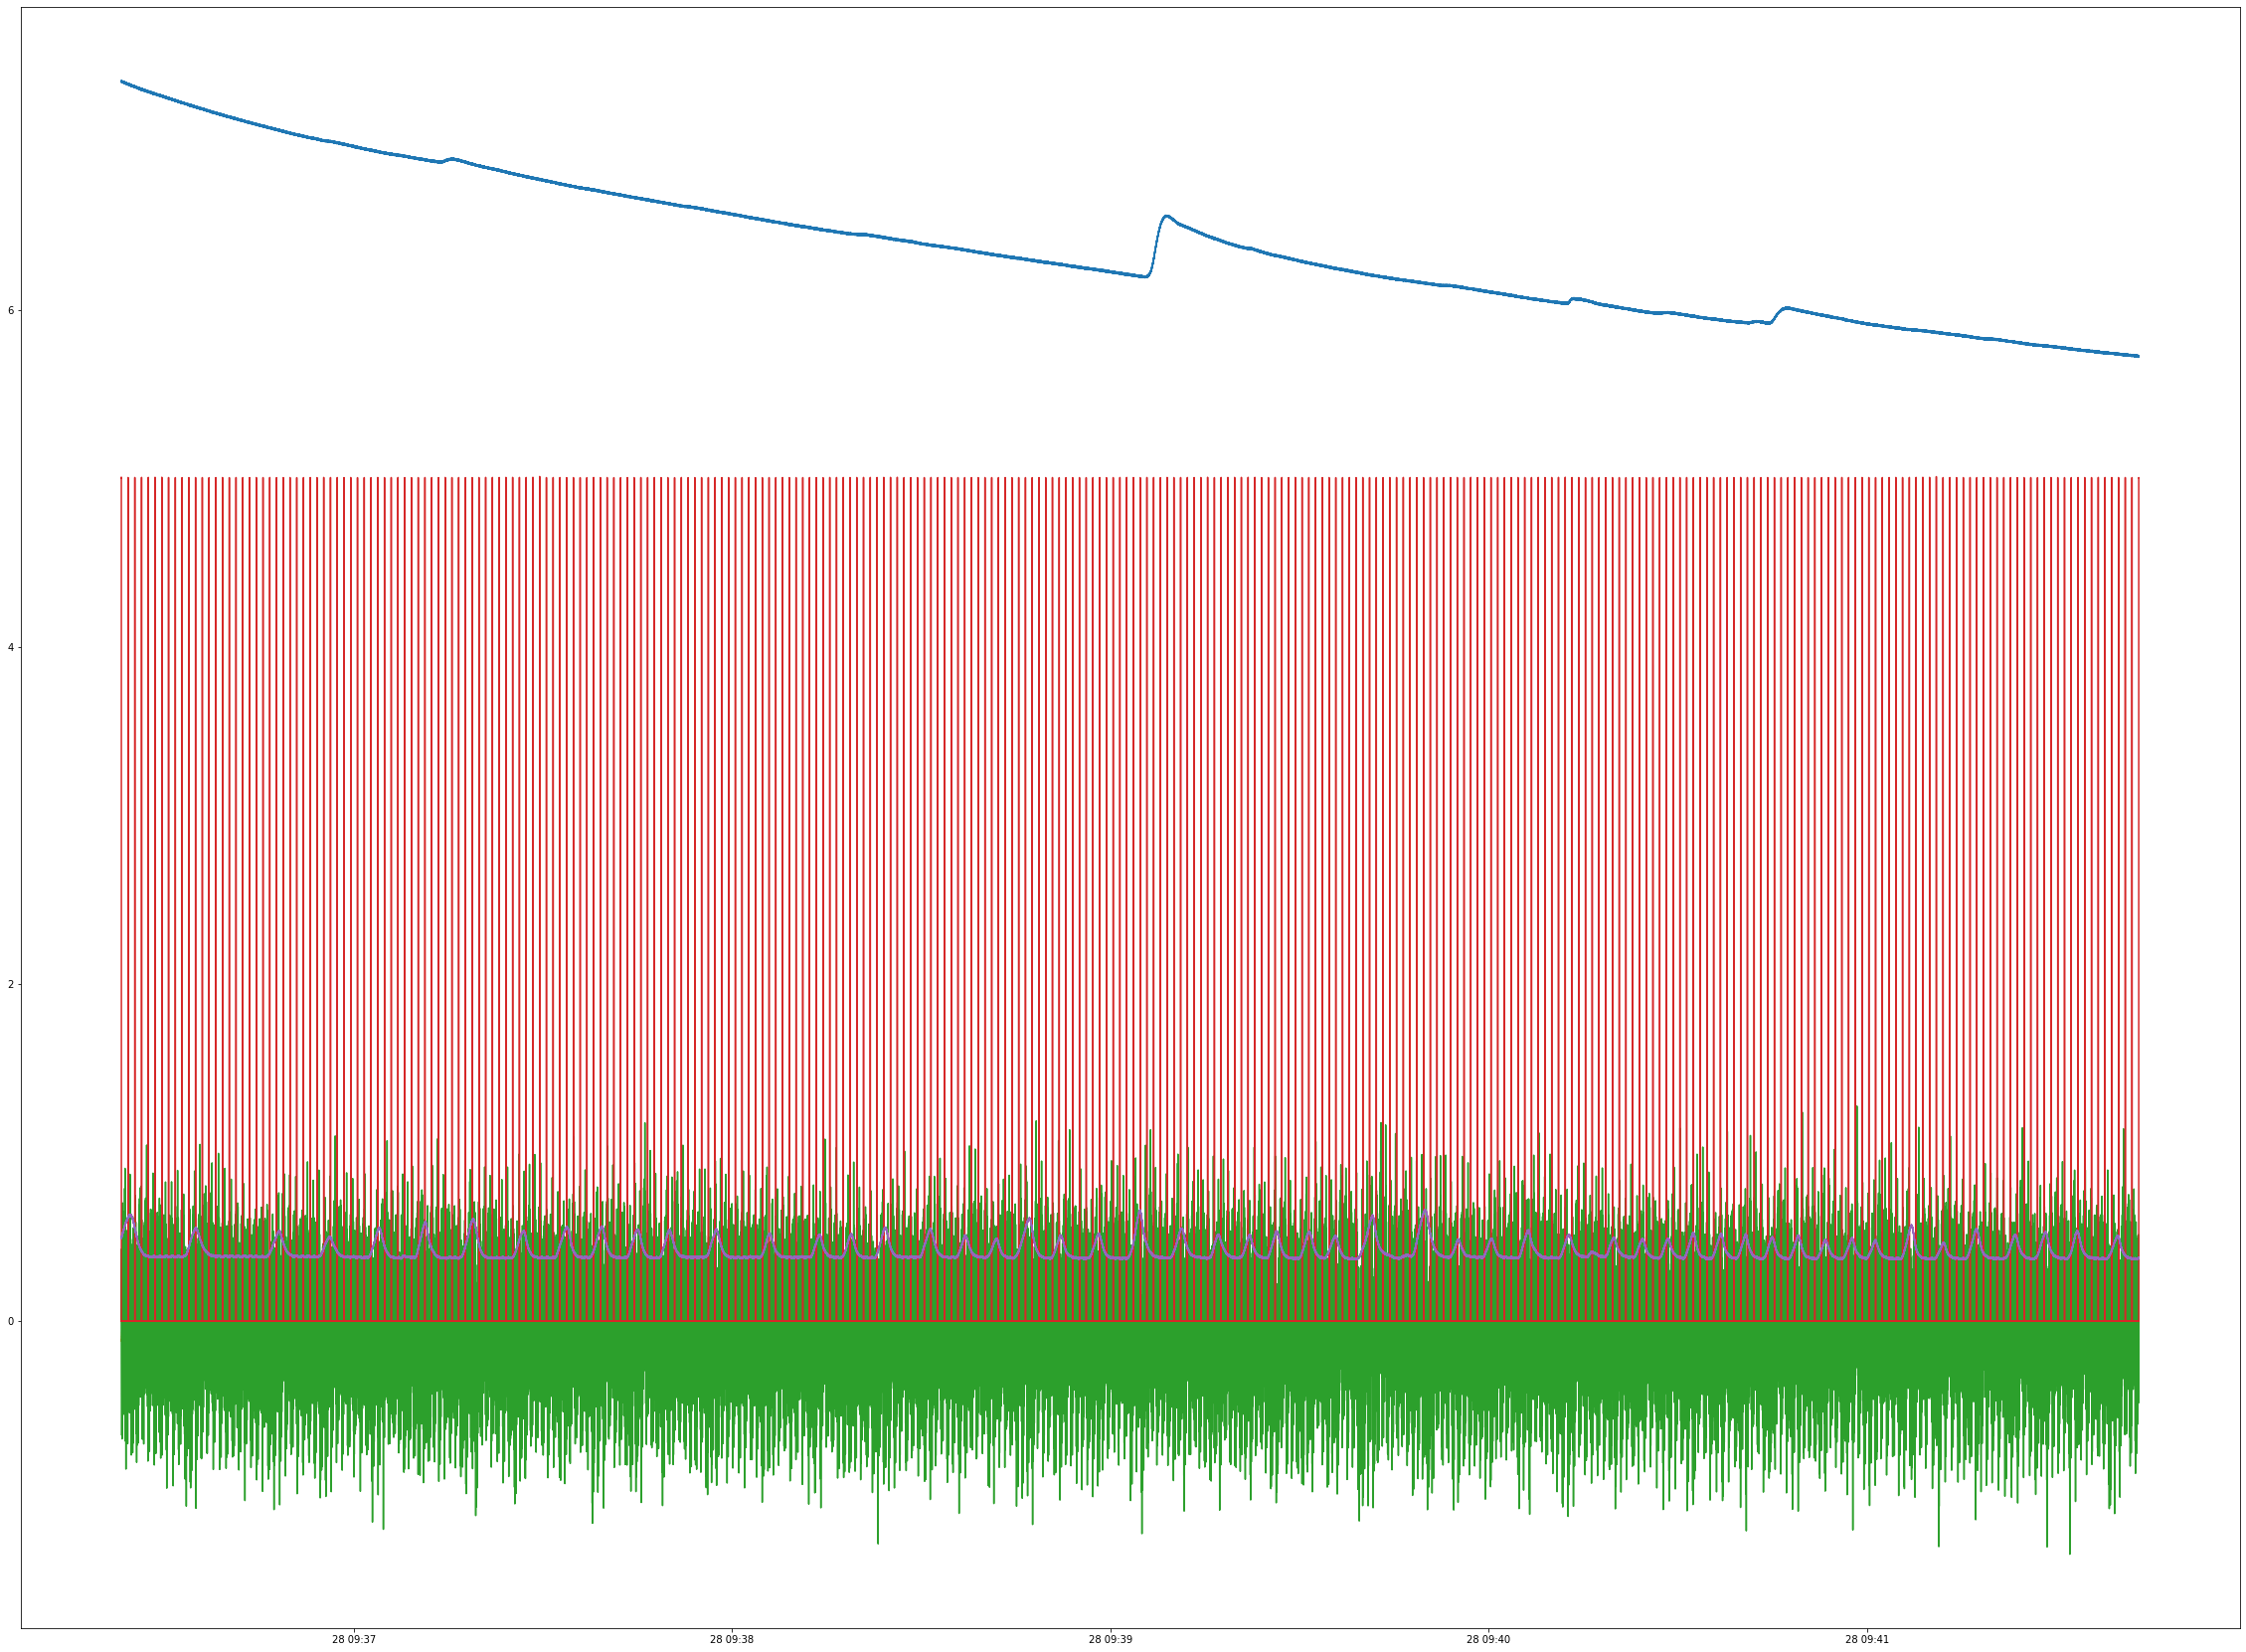

In [25]:
plt.plot(block03)